<a href="https://colab.research.google.com/github/0616039/IMVFX_HW2/blob/main/IMVFX_HW2_pix2pix_ipynb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework2 - pix2pix
This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this homework, you are required to build a type of conditional GAN for image-to-image translation.

Should you have any questions, contact TA via <br/> ee81280@gmail.com


Sample code for cGAN, include the structure and train function.
You can start form this file or write your own structure and train function.
You can also modify anything in this file for training.

What you need to do:
1. Load your dataset.
2. Train the pix2pix model and convert images from a source domain to a target domain (image-to-image translation).
3. Plot the generator and discriminator loss.
4. Use trained model to do image-to-image translation on the test dataset 


If you not familiar with Colab, [here](https://colab.research.google.com/drive/1ecb4-tImhe2CD6DSzxJtt63CAxt2c_Ap) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment


## Packages Installation

In [6]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

## Import Packages

First, we need to import packages that will be used later.

In [7]:
import os
import glob 
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Random seed
Set the random seed to a certain value for reproducibility.

In [8]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(123)

# Download dataset
Download dataset via **gdown**.

You only need to choose portrait or landscape dataset to train your model.


Or you can download the dataset from google drive <br/> 
https://drive.google.com/file/d/1UqbM-upR2HOMauj0m6E4ci7aV3jvaOC1/view?usp=sharing

And the unzipped tree structure is like 
```
dataset/facades/
  train/
    ├── 1.jpg
    ├── 2.jpg
    ├── ...
  test/
    ├── 1.jpg
    ├── 2.jpg
    ├── ...
  val/
    ├── 1.jpg
    ├── 2.jpg
    ├── ...
```

In [9]:
!gdown https://drive.google.com/uc?id=1UqbM-upR2HOMauj0m6E4ci7aV3jvaOC1 --output "{workspace_dir}/facades.zip"

Downloading...
From: https://drive.google.com/uc?id=1UqbM-upR2HOMauj0m6E4ci7aV3jvaOC1
To: /content/facades.zip
100% 30.2M/30.2M [00:00<00:00, 91.1MB/s]


In [10]:
!unzip -o -q "{workspace_dir}/facades.zip" -d "{workspace_dir}/dataset"

## Show a training data

(512, 256)


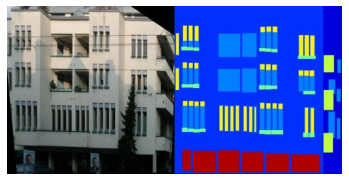

In [11]:
img_path = workspace_dir + "/dataset/facades/train/1.jpg"
sample_image = Image.open(img_path)
# Each original image is of size 512 x 256 containing two 256 x 256 images:
print(sample_image.size)
plt.figure()
plt.axis("off")
plt.imshow(sample_image)

# Hyperparameters and Initialization
Let’s define some inputs for the run later:

In [12]:
# Root directory for dataset
dataroot = "dataset/facades"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 1

# The size of images 
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# The weight for L1 loaa
lamb = 100

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Save checkpoints every few epochs
save_steps = 5

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# log(img), checkpoints and results directory
log_dir = os.path.join(workspace_dir, 'logs/pix2pix')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints/pix2pix')
result_dir = os.path.join(workspace_dir, 'results/pix2pix')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Load training Data

In [13]:
class CustomDataset(Dataset):
    def __init__(self, root, subfolder='train', transform=None):
        super(CustomDataset, self).__init__()
        self.path = os.path.join(root, subfolder)
        self.subfolder = subfolder
        self.image_filenames = [x for x in sorted(os.listdir(self.path))]
        self.resize_scale = 286
        self.crop_size = 256
        self.transform = transform

    def __getitem__(self, index):
        # Load Image
        img_path = os.path.join(self.path, self.image_filenames[index])
        img = Image.open(img_path)
        # Pay attention to the position of the source and target images
        input = img.crop((img.width // 2, 0, img.width, img.height))
        target = img.crop((0, 0, img.width // 2, img.height))

        if self.subfolder == 'train':
            # Data augumentation for training set
            # Resize 
            input = input.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            target = target.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            # Random crop
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            input = input.crop((x, y, x + self.crop_size, y + self.crop_size))
            target = target.crop((x, y, x + self.crop_size, y + self.crop_size))
            # Random Horizontal Flip
            if random.random() < 0.5:
                input = input.transpose(Image.FLIP_LEFT_RIGHT)
                target = target.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            input = self.transform(input)
            target = self.transform(target)
     
        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [14]:
# Define training data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the train dataset
train_dataset = CustomDataset(dataroot, subfolder='train', transform=transform)
# Create the train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Create the validation dataset
val_dataset = CustomDataset(dataroot, subfolder='val', transform=transform)
# Create the validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

# Setup Model
Here, we use pix2pix as the model structure. Feel free to modify your own model structure.

## Weight Initialization

In [15]:
# custom weights initialization called on netG and netD
def weights_init(net):
    def init_func(m):
      classname = m.__class__.__name__
      if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      
    net.apply(init_func)

## Generator

In [16]:
class Generator(nn.Module):
    """Generator network with U-Net."""
    def __init__(self):
        super().__init__()

        # U-Net Encoder 
        # 256 * 256
        self.en_layer1 = nn.Sequential(
            nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1)
        )
        # 128 * 128
        self.en_layer2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2)
        )
        # 64 * 64
        self.en_layer3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4)
        )
        # 32 * 32
        self.en_layer4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 4, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8)
        )
        # 16 * 16
        self.en_layer5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8)
        )
        # 8 * 8
        self.en_layer6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8)
        )
        # 4 * 4
        self.en_layer7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8)
        )
        # 2 * 2
        self.en_layer8 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1),
        )


        # U-Net Decoder
        # 1 * 1
        self.de_layer1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.Dropout(p=0.5)
        )
        # 2 * 2
        self.de_layer2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8 * 2, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.Dropout(p=0.5)
        )
        # 4 * 4
        self.de_layer3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8 * 2, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.Dropout(p=0.5)
        )
        # 8 * 8
        self.de_layer4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8 * 2, ngf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 8)
        )
        # 16 * 16
        self.de_layer5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8 * 2, ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4)
        )
        # 32 * 32
        self.de_layer6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4 * 2, ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2)
        )
        # 64 * 64
        self.de_layer7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2 * 2, ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.Dropout(p=0.5)
        )
        # 128 * 128
        self.de_layer8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):

        # 1：Encoder
        en1_out = self.en_layer1(x)
        en2_out = self.en_layer2(en1_out)
        en3_out = self.en_layer3(en2_out)
        en4_out = self.en_layer4(en3_out)
        en5_out = self.en_layer5(en4_out)
        en6_out = self.en_layer6(en5_out)
        en7_out = self.en_layer7(en6_out)
        en8_out = self.en_layer8(en7_out)

        # 2：Decoder
        de1_out = self.de_layer1(en8_out)
        de1_cat = torch.cat([de1_out, en7_out], 1)
        de2_out = self.de_layer2(de1_cat)
        de2_cat = torch.cat([de2_out, en6_out], 1)
        de3_out = self.de_layer3(de2_cat)
        de3_cat = torch.cat([de3_out, en5_out], 1)
        de4_out = self.de_layer4(de3_cat)
        de4_cat = torch.cat([de4_out, en4_out], 1)
        de5_out = self.de_layer5(de4_cat)
        de5_cat = torch.cat([de5_out, en3_out], 1)
        de6_out = self.de_layer6(de5_cat)
        de6_cat = torch.cat([de6_out, en2_out], 1)
        de7_out = self.de_layer7(de6_cat)
        de7_cat = torch.cat([de7_out, en1_out], 1)
        de8_out = self.de_layer8(de7_cat)

        return de8_out

## Discriminator

In [17]:
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""

    def __init__(self):
        super(Discriminator, self).__init__()

        # 256 * 256
        self.layer1 = nn.Sequential(
            nn.Conv2d(nc * 2, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 128 * 128
        self.layer2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 64 * 64
        self.layer3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 32 * 32
        self.layer4 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 31 * 31
        self.layer5 = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )
        # 30 * 30 : Output patch size

    def forward(self, x):
        layer1_out = self.layer1(x)
        layer2_out = self.layer2(layer1_out)
        layer3_out = self.layer3(layer2_out)
        layer4_out = self.layer4(layer3_out)
        layer5_out = self.layer5(layer4_out)
        return layer5_out

# Train

## Initialization for Pix2Pix model

In [18]:
###################################################################################################
# TODO: Create the Generator by the class and Apply the weights initialize function
# Implementation 1-5
###################################################################################################

# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netG)

# Print the model
print(netG)


Generator(
  (en_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (en_layer2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_size=(4, 4), stride

In [19]:
######################################################################################################
# TODO: Create the Discriminator by the class and Apply the weights initialize function
# Implementation 1-5
######################################################################################################
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netD)

# Print the model
print(netD)


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padd

In [21]:
###############################################################################################################
# TODO: Initialize Loss functions (BCE Loss & L1 Loss)
#     and Setup Adam optimizers for both Generator and Discriminator
# Implementation 1-5
################################################################################################################
# Initialize Loss functions
criterionGAN = nn.BCELoss().to(device)
L1_loss = torch.nn.L1Loss().to(device)
# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = optim.SGD(netD.parameters(), lr=lr, momentum=0.9)
# optimizerG = optim.SGD(netG.parameters(), lr=lr, momentum=0.9)


## Training loop

Starting Training Loop...


  Iters     Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step             
 400/400  00:01:50<00:00:00  3.61it/s  0.0705  38.9482    1    399              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Show one evalutation result......


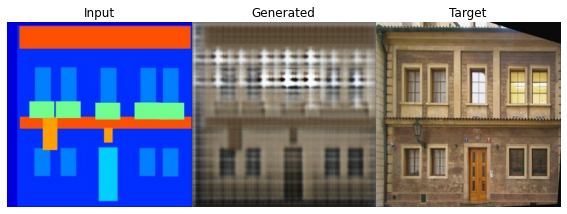

Evaluation done!


  Iters     Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step             
 400/400  00:01:50<00:00:00  3.61it/s  0.0862  46.1529    2    799              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Show one evalutation result......


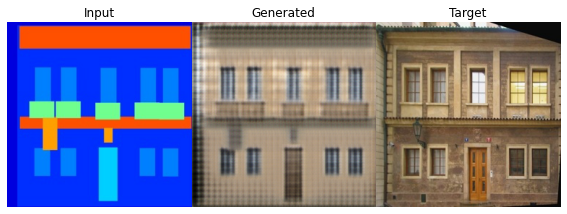

Evaluation done!


  Iters     Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step             
 400/400  00:01:50<00:00:00  3.62it/s  0.0977  43.6345    3    1199             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Show one evalutation result......


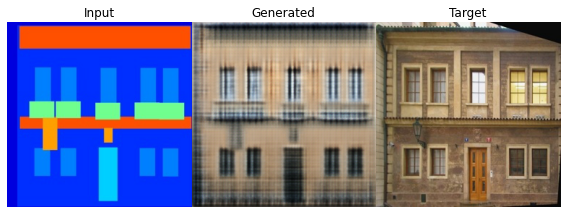

Evaluation done!


  Iters     Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step             
 400/400  00:01:50<00:00:00  3.61it/s  0.2294  36.3526    4    1599             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Show one evalutation result......


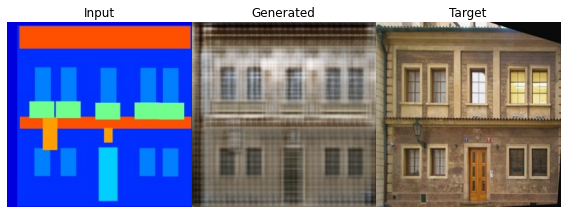

Evaluation done!


  Iters     Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step             
 400/400  00:01:51<00:00:00  3.60it/s  0.2738  45.4032    5    1999             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Show one evalutation result......


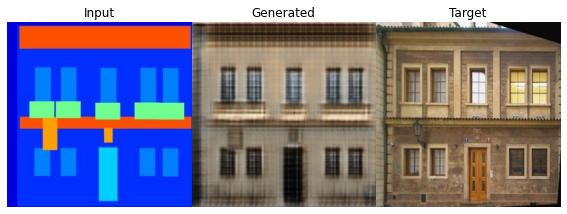

Evaluation done!


In [27]:
err_G = []
err_D = []

# Training Loop
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    progress_bar = qqdm(train_dataloader)
    netG.train()
    netD.train()
    # For each batch in the dataloader
    for i, data in enumerate(progress_bar):

        ############################
        # (1) Update D network
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_a, real_b = data[0].to(device), data[1].to(device)
        real_ab = torch.cat((real_a, real_b), 1)  # real pairs

        '''
        TODO:
        1. Forward pass real pairs through Discriminator 
        2. Calculate BCE loss between Discriminator's outputs and real labels
        '''
        # train with real
        pred_real = netD.forward(real_ab).view(-1)
        label = torch.full((900,), real_label, dtype=torch.float, device=device)
        errD_real = criterionGAN(pred_real, label)
        
        ## Train with all-fake batch
        '''
        TODO: 
        1. Forward pass real_a through Generator to generate fake image
        2. Concatenate real_a and fake image to make fake pairs
        3. Forward pass fake pairs through Discriminator 
        4. Calculate BCE loss between Discriminator's outputs and fake labels
        5. Sum the loss, backward pass to calculate the gradients and update Discriminator (Hint: page 20 in ppt)
        '''

        # train with fake
        fake_b = netG(real_a)
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab.detach()).view(-1)
        label = torch.full((900,), fake_label, dtype=torch.float, device=device)
        errD_fake = criterionGAN(pred_fake, label)

        
        
        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)*0.5
        # Calculate the gradients for this batch
        errD.backward()
        # Update D
        optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        '''
        TODO: 
        1. Forward pass fake pairs through Discriminator 
        2. Calculate BCE loss between Discriminator's outputs and real labels
        3. Calculate L1 loss between fake image and real_b
        4. Sum the loss (Hint: BCELoss() + lamb * L1Loss())
        5. Pass the loss backward to calculate the gradient and update Generator
        '''
        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab).view(-1)
        label = torch.full((900,), real_label, dtype=torch.float, device=device)
        errG_bce = criterionGAN(pred_fake, label)

        # Second, G(A) = B
        errG_L1 = L1_loss(fake_b, real_b) * lamb
        
        errG = errG_bce + errG_L1
        
        errG.backward()

        optimizerG.step()


        # Output training stats\
        # Set the info of the progress bar
        # Note that the value of the GAN loss is not directly related to
        # the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(errD.item(), 4),
            'Loss_G': round(errG.item(), 4),
            'Epoch': epoch+1,
            'Step': iters,
        })
        err_G.append(round(errD.item(), 4))
        err_D.append(round(errG.item(), 4))
        iters += 1

    # Evaluation 
    netG.eval()
    for idx, data in enumerate(val_dataloader):
        input, target = data[0].to(device), data[1].to(device)
        output = netG(input)
        # Show result for test data
        fig_size = (input.size(2) * 3 / 100, input.size(3)/100)
        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        imgs = [input.cpu().data, output.cpu().data, target.cpu().data]
        for ax, img in zip(axes.flatten(), imgs):
            ax.axis('off')
            # Scale to 0-255
            img = img.squeeze()
            img = (((img - img.min()) * 255) / (img.max() - img.min())).numpy().transpose(1, 2, 0).astype(np.uint8)
            ax.imshow(img, cmap=None, aspect='equal')
        axes[0].set_title("Input")
        axes[1].set_title("Generated")
        axes[2].set_title("Target")
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.subplots_adjust(bottom=0)
        fig.subplots_adjust(top=1)
        fig.subplots_adjust(right=1)
        fig.subplots_adjust(left=0)
        # Save evaluation results
        if (epoch+1) % save_steps == 0:
          dir = os.path.join(log_dir, f'Epoch_{epoch+1:03d}')
          os.makedirs(dir, exist_ok=True)
          filename = os.path.join(dir, f'{idx+1}.png')
          plt.savefig(filename)
        if idx == 0:
            print('Show one evalutation result......')
            plt.show()  # Show the first result
        else:
            plt.close()
    print('Evaluation done!')

    # Save the checkpoints.
    if (epoch+1) % save_steps == 0:
        netG_out_path = os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(epoch+1))
        netD_out_path = os.path.join(ckpt_dir, 'netD_epoch_{}.pth'.format(epoch+1))
        torch.save(netG.state_dict(), netG_out_path)
        torch.save(netD.state_dict(), netD_out_path)

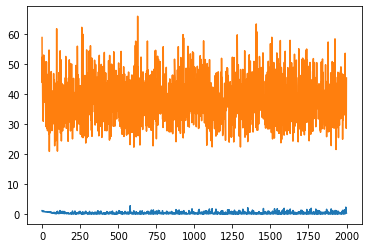

In [28]:
###############################################################################
# TODO: Plot the training loss value of discriminator and generator
# Implementation 1-6
###############################################################################

import matplotlib.pyplot as plt
plt.plot(err_G)
plt.plot(err_D)
plt.show()

# Inference

The trained model should has been saved in the directory(ckpt_dir) you specified.

Use the trained model to do image-to-image translation!

## Load trained model

In [29]:
import torch

# load gernerator
device = torch.device("cuda")
netG = Generator()
netG.load_state_dict(torch.load(os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(num_epochs))))
netG.eval()
netG.to(device)

Generator(
  (en_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (en_layer2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (en_layer5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_size=(4, 4), stride

## Load testing data

In [30]:
# Define data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create the test dataset
test_dataset = CustomDataset(dataroot, subfolder='test', transform=transform)
# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=workers)

## Test and show images

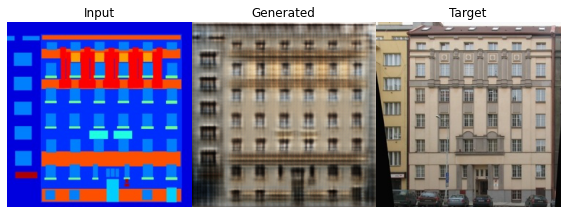

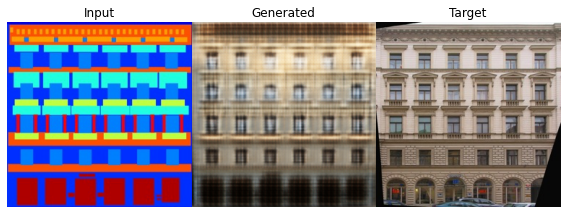

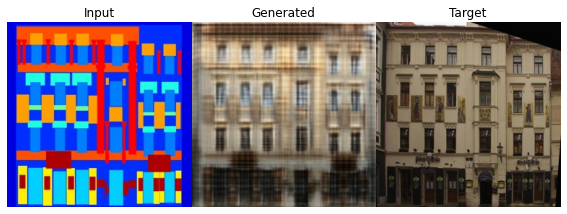

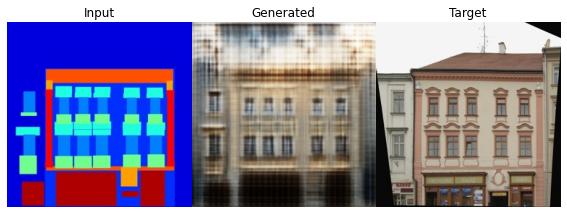

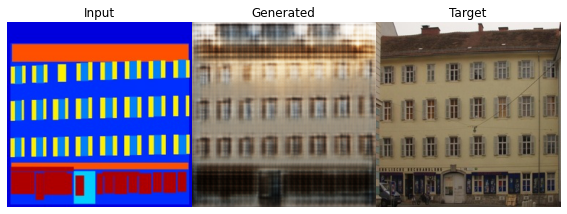

In [31]:
for i, data in enumerate(test_dataloader):
    # input & target image data
    input, target = data[0].to(device), data[1].to(device)

    ################################################################################################
    # TODO: Forward pass input image through Generator to do image-to-image translation
    # Implementation 1-7
    ################################################################################################

    # Pass input image through Generator
    output = netG(input)

    # Show result for test data
    fig_size = (input.size(2) * 3 / 100, input.size(3)/100)
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input.cpu().data, output.cpu().data, target.cpu().data]   # The output is generated by Generator 
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    axes[0].set_title("Input")
    axes[1].set_title("Generated")
    axes[2].set_title("Target")

    # Save result
    save_fn = os.path.join(result_dir, 'Test_result_{:d}.jpg'.format(i+1))
    fig.subplots_adjust(bottom=0)
    fig.subplots_adjust(top=1)
    fig.subplots_adjust(right=1)
    fig.subplots_adjust(left=0)
    plt.savefig(save_fn)

    if i < 5:
        plt.show()  # Show the first five test results
    else:    
        plt.close()
